# COGS 118A - Final Project

# Rotten Tomatoes Rating Analysis

# Names


- Eric Lin
- Cecilia Martinez
- Jared Singletary
- Finn St-John

# Abstract 
We will investigate the connection between features of a movie and its rating on the popular movie reviews website Rotten Tomatoes. This website classifies each movie as one of three categories: rotten, fresh, and certified fresh. We plan to use the non-cinematic features of movies to classify them into one of these three categories. Each data point will represent a movie and many of its characteristics. These features include things like genre, release date, runtime, etc. Almost all of these features are nominal or interval. We will be performing classification on our test data to predict the Rotten Tomatoes status of a movie. The status includes the aforementioned three categories. For model selection, we will perform grid-search cross validation and select the model with the best generalization. Since neither false positives nor false negatives pose more risk than the other in the context of our problem, we will evaluate the effectiveness of our model primarily using its f1 score, as this provides a metric that balances the impact of false negatives and false positives.


# Background

Movie ratings are an important aspect of the film industry, with many consumers relying on them to guide their viewing decisions. Rotten Tomatoes is a popular website that provides ratings based on the percentage of positive reviews for a given movie. These ratings are divided into three categories: rotten for scores below 60%, fresh for scores above 60%, and certified fresh for scores above 75% and at least 5 top critic reviews. Additionally, the website includes an audience score as a separate metric<sup id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>. Despite the popularity of such rating systems, recent research has raised questions about their accuracy in reflecting the opinions of the general public.

In a recent study<sup id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>, researchers found that movie rating scores on Rotten Tomatoes do not necessarily align with the sentiment of audience reviews. This highlights the need for a more nuanced approach to understanding audience preferences. Furthermore, movie popularity can vary significantly across genres, with certain genres like horror, comedy, mystery, and action performing poorly compared to others such as documentary, classics, and animation<sup id="cite_ref-3"><a href="#cite_note-3">[3]</a></sup>. These differences in popularity may impact the effectiveness of a machine learning algorithm trained on movie ratings data, suggesting the need for careful consideration of genre in the analysis.


# Problem Statement

The problem that our project is trying to solve is predicting the rotten tomatoes rating for a movie based on movie features including genre, release date, runtime, and content rating. We will do this by using machine learning algorithms like a random forest classifier and logistic regression to predict if a movie will receive a "fresh" rotten tomato score or a "rotten" score. 

The dataset we use makes this very much quantifiable, although certain variables are categorical and must therefore be either one-hot encoded or ordinally encoded so that we can work with it mathematically. We will divide our dataset up into 2/3 training data and 1/3 testing data and then use the metric of "Precision" to determine the success of our algorithm. 

# Data

Since we are trying to do an analysis of movies and how their features relate with their reviews, an ideal dataset for our project will allow us to compare several movie features with their review scores. 

Rotten Tomatoes Movies dataset
- https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_movies.csv
- This dataset has 17,712 observations and 22 variables per observation. 
- An observation in this dataset describes a single movie with many pieces of information about it.
- Some important variables are the rotten tomatoes score, the genre of the movie, and the director. 
- Since there is a good amount of categorical variables like genre and director, we will likely need to use one-hot encoding to clean up that data. 


### Data Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

We read in our rotten tomatoes csv and select only the columns with the information we have deemed to be critical to our machine learning algorithm.

In [2]:
movies = pd.read_csv('data/rotten_tomatoes_movies.csv')
critical_columns = ['movie_title', 'content_rating', 'genres', 'directors', 'runtime', 'tomatometer_status', 
                    'tomatometer_rating', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
                    'tomatometer_rotten_critics_count', 'original_release_date']
movies = movies[critical_columns]
movies.head()

,movie_title,content_rating,genres,directors,runtime,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,original_release_date
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,119.0,Rotten,49.0,43,73,76,2010-02-12
1,Please Give,R,Comedy,Nicole Holofcener,90.0,Certified-Fresh,87.0,44,123,19,2010-04-30
2,10,R,"Comedy, Romance",Blake Edwards,122.0,Fresh,67.0,2,16,8,1979-10-05
3,12 Angry Men (Twelve Angry Men),NR,"Classics, Drama",Sidney Lumet,95.0,Certified-Fresh,100.0,6,54,0,1957-04-13
4,"20,000 Leagues Under The Sea",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,127.0,Fresh,89.0,5,24,3,1954-01-01


We know that the genre of the movie will be an important predictor, so we collect all the different genres into a set so we can see the unique values. 

In [3]:
genre_set = set()
for i in movies['genres']:
    if (type(i) == str):
        for j in i.split(','):
            j = j.strip()
            genre_set.add(j)
print(genre_set)

{'Sports & Fitness', 'Television', 'Comedy', 'Science Fiction & Fantasy', 'Special Interest', 'Anime & Manga', 'Classics', 'Faith & Spirituality', 'Action & Adventure', 'Animation', 'Horror', 'Gay & Lesbian', 'Western', 'Romance', 'Mystery & Suspense', 'Drama', 'Art House & International', 'Documentary', 'Musical & Performing Arts', 'Kids & Family', 'Cult Movies'}


We are interested in how many null values are in our csv because they can cause errors in our machine learning algorithms. We look through the columns and see how many null values they all have.

In [4]:
for i in movies.columns:
    print(i,movies[i].isnull().values.sum())

movie_title 0
content_rating 0
genres 19
directors 194
runtime 314
tomatometer_status 44
tomatometer_rating 44
tomatometer_top_critics_count 0
tomatometer_fresh_critics_count 0
tomatometer_rotten_critics_count 0
original_release_date 1166


Since there aren't very many null values across our columns, we will just drop all the null values to avoid any problems later on. 

In [5]:
movies = movies.dropna()
movies.shape

(16208, 11)

Genres list is a categorigal variable with no order. So we one hot encoded it.
To one hot encode the genres, first made genres into a new genres list. Then, applied Series to each 'genres list' element

In [6]:
movies['genres list'] = movies['genres'].str.split(', ', expand=False)
genres_series = movies['genres list'].apply(pd.Series).stack()
genres_encoded = pd.get_dummies(genres_series).groupby(level=0).sum()
# movies = pd.concat([movies, genres_encoded], axis=1)

genres_list = []
for i in genres_encoded.index:
    row_list = genres_encoded.loc[i, :].values.flatten().tolist()
    genres_list.append(row_list)

movies['genres_encoded'] = genres_list

movies['content_rating'].value_counts()

R        6092
NR       4507
PG-13    2863
PG       2067
G         644
NC17       35
Name: content_rating, dtype: int64

Ratings have an order to it, so we turned it into an ordinal numerical value.

In [7]:
ratings = {'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3, 'NC17': 4, 'NR': 5}

movies['content_rating_id'] = movies['content_rating'].map(ratings)

We turned original release date into a pandas date time object so we can easily compare it to each other

In [8]:
movies['original_release_date'] = pd.to_datetime(movies['original_release_date'])

In [9]:
#reordering the columns
reordered_columns = ['movie_title', 'content_rating', 'content_rating_id', 'genres', 'genres_encoded', 'directors',
                    'runtime', 'original_release_date', 'tomatometer_status', 'tomatometer_rating', 
                    'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']
movies = movies[reordered_columns]
movies.head()

,movie_title,content_rating,content_rating_id,genres,genres_encoded,directors,runtime,original_release_date,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,Percy Jackson & the Olympians: The Lightning T...,PG,1,"Action & Adventure, Comedy, Drama, Science Fic...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Chris Columbus,119.0,2010-02-12,Rotten,49.0,43,73,76
1,Please Give,R,3,Comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Nicole Holofcener,90.0,2010-04-30,Certified-Fresh,87.0,44,123,19
2,10,R,3,"Comedy, Romance","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Blake Edwards,122.0,1979-10-05,Fresh,67.0,2,16,8
3,12 Angry Men (Twelve Angry Men),NR,5,"Classics, Drama","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Sidney Lumet,95.0,1957-04-13,Certified-Fresh,100.0,6,54,0
4,"20,000 Leagues Under The Sea",G,0,"Action & Adventure, Drama, Kids & Family","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",Richard Fleischer,127.0,1954-01-01,Fresh,89.0,5,24,3


In [10]:
movies.shape

(16208, 13)

### Data Visualizations

First we do a heatmap to get an idea of possible correlations between variables. 

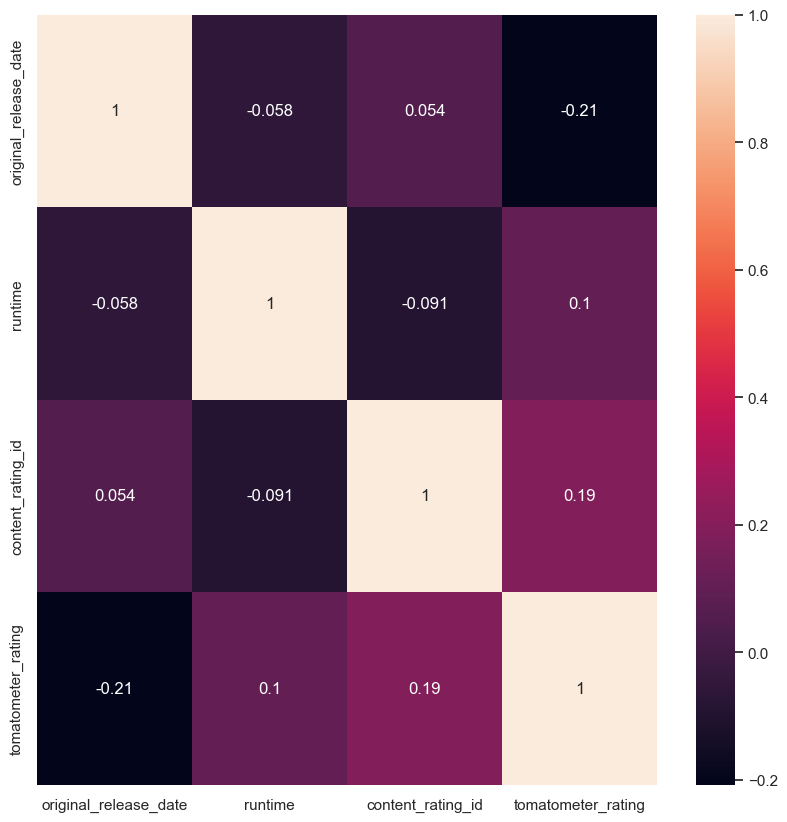

In [14]:
selected_columns = ['original_release_date', 'runtime', 'content_rating_id', 'tomatometer_rating']
movies_corr = movies.loc[:,selected_columns].corr(numeric_only=False)
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(movies_corr, annot = True);

From this heatmap we can see that there is a slight negative correlation (-0.21) which tells us that there is some truth to the idea that critics give higher ratings to older movies and lower ratings to newer ones. 

There is also a slight positive correlation (0.14) between the content rating of a movie and the critic ratings which would hint at movies with a more adult content rating receiving higher reviews than movies targeted towards kids. 

Next we figure out the percentage of each genre of movie that are given Fresh or Certified-Fresh reviews in order to see which genres are highest and lowest rated. 

In [11]:
genres_dict = {}
for i in range(len(genre_set)):
    genres_dict[i] = [0,0]
    
for index in movies.index:
    genres_enc = movies.loc[index,'genres_encoded']
    tomato = movies.loc[index,'tomatometer_status']
    
    for i in range(len(genres_enc)):
        if genres_enc[i] == 1:
            if tomato == 'Fresh' or tomato == 'Certified-Fresh':
                genres_dict[i][0] += 1
            else:
                genres_dict[i][1] += 1

        
print(genres_dict)

{0: [1545, 1753], 1: [317, 219], 2: [15, 3], 3: [1703, 614], 4: [1331, 258], 5: [2532, 2734], 6: [56, 42], 7: [1574, 221], 8: [5410, 3532], 9: [43, 28], 10: [34, 38], 11: [776, 1040], 12: [496, 529], 13: [669, 262], 14: [1588, 1702], 15: [1012, 804], 16: [844, 884], 17: [956, 195], 18: [122, 43], 19: [159, 52], 20: [184, 105]}


In [12]:
movies_to_tomato = {}
for i in genres_dict:
    movies_to_tomato[genres_encoded.columns[i]] = genres_dict[i][0]/float(genres_dict[i][0]+genres_dict[i][1])
    
print(movies_to_tomato)

{'Action & Adventure': 0.468465736810188, 'Animation': 0.5914179104477612, 'Anime & Manga': 0.8333333333333334, 'Art House & International': 0.735002157962883, 'Classics': 0.8376337319068596, 'Comedy': 0.4808203570072161, 'Cult Movies': 0.5714285714285714, 'Documentary': 0.8768802228412256, 'Drama': 0.6050100648624469, 'Faith & Spirituality': 0.6056338028169014, 'Gay & Lesbian': 0.4722222222222222, 'Horror': 0.42731277533039647, 'Kids & Family': 0.48390243902439023, 'Musical & Performing Arts': 0.7185821697099892, 'Mystery & Suspense': 0.4826747720364742, 'Romance': 0.5572687224669604, 'Science Fiction & Fantasy': 0.48842592592592593, 'Special Interest': 0.8305821025195482, 'Sports & Fitness': 0.7393939393939394, 'Television': 0.7535545023696683, 'Western': 0.6366782006920415}


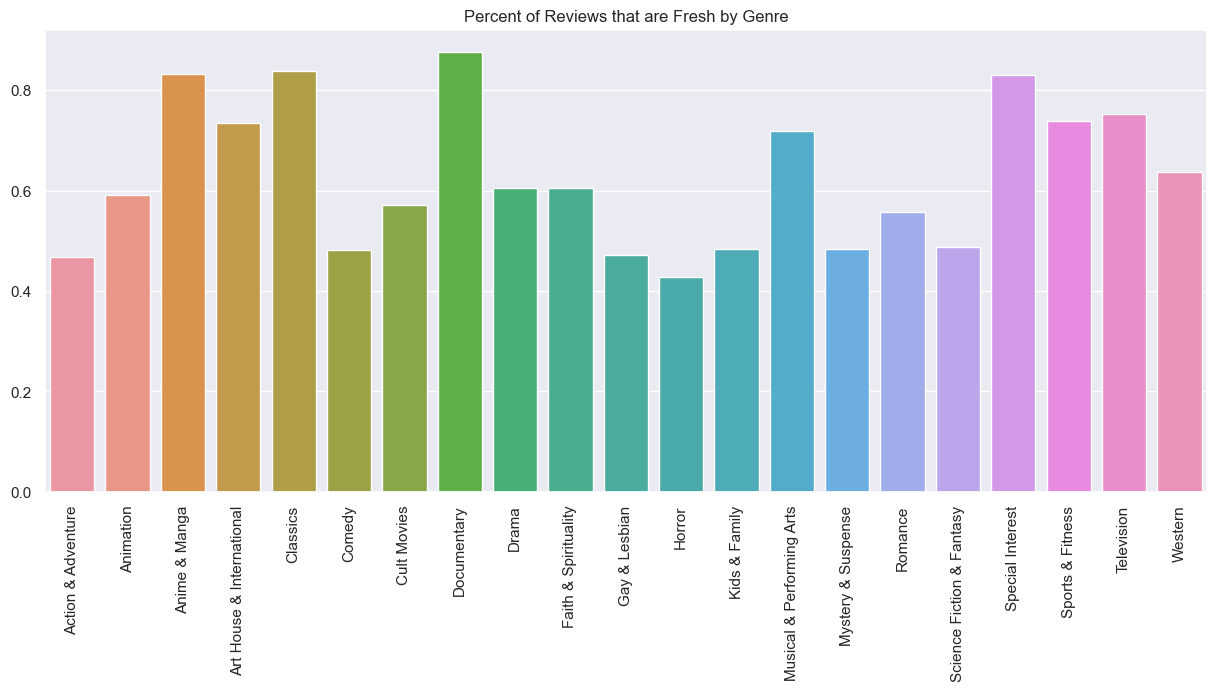

In [17]:
keys = list(movies_to_tomato.keys())
vals = [float(movies_to_tomato[k]) for k in keys]

sns.set(rc={"figure.figsize":(15, 6)})
plot = sns.barplot(x=keys, y=vals)
plot.set_title("Percent of Reviews that are Fresh by Genre")
plot.set_xticklabels(labels = keys,rotation=90);

From this bar graph we can see that some genres receive higher ratings than others. For example, Documentaries, Classics, Anime & Manga, and Special Interest movies are much more likely to receive positive reviews than a genre like Horror, so we would expect our Machine Learning algorithm to predict higher ratings for those genres on average than for Horror movies. 

Lastly we wanted to look at the runtime of movies compared with the rating the movie received. 

Text(0.5, 1.0, 'Distribution of Movie Ratings and Runtime')

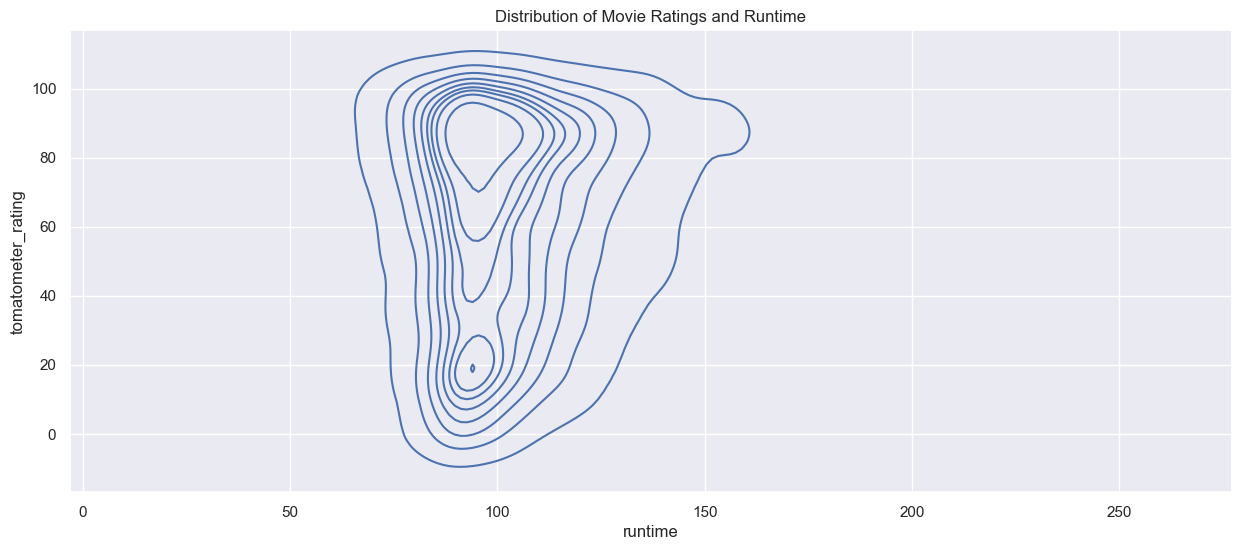

In [18]:
sns.set(rc={"figure.figsize":(15, 6)})
plot = sns.kdeplot(x=movies['runtime'], y=movies['tomatometer_rating'])
plot.set_title("Distribution of Movie Ratings and Runtime")

We see that most movies end up being around 90 minutes long. There seems to be a very slight trend towards a higher rating with movies between 110-150 minutes long, but overall there is a very slight positive correlation between runtime and rating. 

# Proposed Solution

We predict that these features, while not completely evident in the content of the movie, will be a large predictor of the movie’s rating. More specifically, we predict that the director will have a large influence on the overall rating given to the movie. Additionally, we predict that certain genres will be rated more highly than others across the board. We believe that a classification model will be able to effectively find a connection between director and rating and genre and rating. We will test each solution using our selected metric: the f1 score of a model. We believe that there is a connection to discover between these non-cinematic characteristics and the rating of the movie, whether it is a large connection or small connection, and therefore believe that a classification model will be able to effectively identify this connection.

The classifiers we have tested are support vector machines, logistic regression, and random forest. There are a two things to consider when selecting our model. We must consider the ability of the model to approximate more complex functions, and we must consider the interpretability of the classifier. SVMs, while powerful are not very interpretable. Logistic Regression is less powerful, but more interpretable. 

After performing grid search cross-validation on these three algorithms, we are most interested in using a random forest classifier.

Because we are looking to discover an inherent connection between certain features of our data, we would like to select the most interpretable model. However, because model interpretability scales inversely with model capacity (the amount of functions a model can approximate), we have to balance these two characteristics. Because we need to find a good medium, we are looking into using a random forest classifier. Random forest classifiers comprise many decision trees. Decision trees are some of the most interpretable classifiers available for use. Additionally, because random forests are ensemble learners, it's acceptable to use a less complex model (decision trees, in this case). 

Using a random forest classifier allows us to get the best of both worlds. Our model will have high interpretability, as well as a high model capacity and high prediction ability.

# Evaluation Metrics

The evaluation model we will use will be based on precision, as it is the most valuable metric to look at in the context of this problem. 

If a filmmaker were to create a movie based on this machine learning algorithm, spending money, time, and effort on a movie that our model predicted would do well, but then flops in reality (false positive), there would be significantly worse consequences for the filmmaker than a movie that’s expected to do poorly but ends up doing really well (false negative). A false negative would have little effect when actually using our model in practice, as filmmakers rarely have the intention of making a bad movie. As such, maximizing the precision score would minimize the amount of false positives, making a more useful model. 

$$Precision = \frac{True\ Positives}{(True\ Positives + False\ Positives)}$$

# Results

Classifiers we tested:

* SVM

* Logistic Regression

* Random Forest

* K-Nearest Neighbors

Each of these can be used as binary classifiers, so they should apply well to our data & problem. This set of algorithms also tests high and low interpretability and high and low complexity/power.

We wanted to explore both which algorithms and hyperparameters could be the best for classifying movies using out features as well as the feature importance in these predictions. Because of this, we wanted to strongly consider using and random forest model as our final model.

Logistic regression, K-nearest neighbors and most importantly random forests, which are just a collection of decision trees, are great for interpreting decisions. Specifically, SciKitLearn's implementation of the random forest classifier very easily allows us to see the importance of each feature in making decisions.

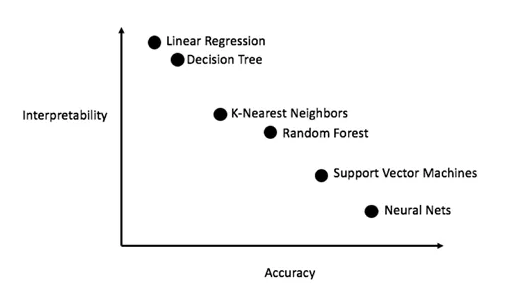

[Link](https://towardsdatascience.com/model-complexity-accuracy-and-interpretability-59888e69ab3d)

This benefit of interpretability unfortunately is usually only possible through sacrificing power. Neural networks, for example, while extremely powerful, are practically impossible to interpret. 

In order to have a balance of both interpretability and power in our validation, we opted to additionally train a support vector machine. Support vector machines, similar to neural networks, are powerful but difficult to interpret.

### Some more data formatting

In [13]:
# encode the tomatometer_status column to be binary

status_encoded = pd.get_dummies(movies['tomatometer_status']).groupby(level=0).sum()

status_list = []
for i in status_encoded.index:
    row_list = status_encoded.loc[i, :].values.flatten().tolist()
    status_list.append(row_list[::-1])

movies['status_encoded'] = status_list

# turn tomatometer status into binary so that we can use binary classifiers

binary_encoding = []
certified_fresh = [0, 0, 1]
fresh = [0, 1, 0]

# for each one hot encoded list
for val in status_list:
    # val is fresh or certified fresh
    if val in [fresh, certified_fresh]:
        binary_encoding.append(1)
    else:
        binary_encoding.append(0)
        
movies['binary_tomatometer_status'] = binary_encoding

# one hot encode content_rating_id

ratings = {
    'G': [1, 0, 0, 0, 0, 0],
    'PG': [0, 1, 0, 0, 0, 0],
    'PG-13': [0, 0, 1, 0, 0, 0],
    'R': [0, 0, 0, 1, 0, 0],
    'NC17': [0, 0, 0, 0, 1, 0],
    'NR': [0, 0, 0, 0, 0, 1]
}

# map the above encodings over the content_rating column
movies['content_rating_one_hot'] = movies['content_rating'].map(ratings)

# create month column
movies['original_release_month'] = [d.month for d in movies['original_release_date']]

# create year column
movies['original_release_year'] = [d.year for d in movies['original_release_date']]

# selected features will be:
selected_columns = ['original_release_month', 'original_release_year', 'genres_encoded', 'runtime', 'content_rating_one_hot']

data = np.array(movies[selected_columns])

# combine all columns including one-hot-encoded columns into single vector
vectorized_data = []
for d in data:
    data_point = []
    for feature in d:
        if type(feature) is list:
            data_point.extend(feature)
        else:
            data_point.append(feature)
    vectorized_data.append(data_point)
    
pd.DataFrame(vectorized_data).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2,2010,1,0,0,0,0,1,0,0,...,0,0,0,119.0,0,1,0,0,0,0
1,4,2010,0,0,0,0,0,1,0,0,...,0,0,0,90.0,0,0,0,1,0,0
2,10,1979,0,0,0,0,0,1,0,0,...,0,0,0,122.0,0,0,0,1,0,0
3,4,1957,0,0,0,0,1,0,0,0,...,0,0,0,95.0,0,0,0,0,0,1
4,1,1954,1,0,0,0,0,0,0,0,...,0,0,0,127.0,1,0,0,0,0,0


## Validation

### Setup

- Import the necessary packges from ScikitLearn and SciPy
- Define some helper functions for displaying the results of a grid search
- Splitting data into train and test data

In [14]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform, truncnorm, randint

#### Defining Helper Functions

`plot_results` was a function from one of the previous homeworks that we completed this quarter. It is used for displaying the results of a grid search cross validation. This function plots each tested classifier's score as well as its error bar. 

`show_best` takes a cross validator as a parameter and displays the best parameters as well as the score that those parameters achieved.

In [15]:
def plot_results(grid_search, alt_cv = False):
    params = grid_search.cv_results_["params"]
    ys = grid_search.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = grid_search.cv_results_["std_test_score"]
    cv_count = grid_search.cv.get_n_splits() if alt_cv else grid_search.cv
    plt.errorbar(xs, ys, yerr / np.sqrt(cv_count), fmt='.k')
    plt.xticks(rotation=90)
    plt.ylabel("score")
    plt.xlabel("params")
    
def show_best(cv):
    print('Best Parameters:')
    print(cv.best_params_)
    print('Score:', cv.best_score_)

#### Defining Parameter Grids

For logistic regression, we decided to test both L1 and L2 regularizers. This meant, however, that we would only be able to test a limited amount of the solvers.

SVM only has a few important hyperparameters to test. Of these, we selected C-value and the kernel type. We decided to test a range of values for C from 1 to 100, as well as both linear and radial basis function kernels.

Random forests, in contrast to SVMs, have a massive amount of hyperparameters available for tuning. We wanted to test a wide range of values for each of these, while also keeping the time it takes to run a grid search at a minimum.

Finally, K-nearest neighbors has a few important hyperparameters to mess with. We wanted to test a wide range of K-values. When setting our K-value, we wanted to keep in mind that higher values of K will overfit more often and lower values of K will underfit more often. We also decided to test each of the training algorithms provided by SciKitLearn.

Additionally, for all grid searches, we realized it would be necessary to use a scaler in the pipeline because some of our features (release year) would be much higher in magnitude than others (one-hot encoded features). By adding a scaler to each pipeline, we are attempting to reduce the imbalance in feature importance that this magnitude difference causes.

In [ ]:
# Logistic Regression Setup
logistic_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('logistic', LogisticRegression(random_state=42))])

logistic_params_gs = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],
    'logistic__solver': ['liblinear', 'saga']
}

logistic_params_rs = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': uniform(0.01, 100),
    'logistic__solver': ['liblinear', 'saga']
}

In [ ]:
# SVM Setup
svm_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(random_state=42))])

svm_params_gs = {
    'svc__C': [1, 5, 10, 100],
    'svc__kernel': ['linear', 'rbf']
}

svm_params_rs = {
    'svc__C': randint(1,100),
    'svc__kernel': ['linear', 'rbf']
}

In [ ]:
# Random Forest Setup
forest_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('forest', RandomForestClassifier(random_state=42))])

forest_params_gs = {
    'forest__n_estimators': [50, 100, 200, 400, 600],
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_depth': [30, 50, 60, 90],
    'forest__min_samples_split': [2, 7, 9, 12],
    'forest__max_features': ['sqrt'],
    'forest__bootstrap': [True]
}

forest_params_rs = {
    'forest__n_estimators': randint(50, 800),
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_depth': randint(30, 100),
    'forest__min_samples_split': randint(2,15),
    'forest__max_features': ['sqrt'],
    'forest__bootstrap': [True]
}

In [ ]:
# K-Nearest Neighbors Setup

knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('neighbors', KNeighborsClassifier())])

knn_params_gs = {
    'neighbors__n_neighbors': [3, 5, 7, 9, 11],
    'neighbors__weights': ['uniform', 'distance'],
    'neighbors__algorithm': ['ball_tree', 'kd_tree', 'brute']
}

Here we split our data into training and testing data.

In [16]:
X = np.array(vectorized_data)
y = np.array(movies['binary_tomatometer_status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Running Each Grid Search

We decided to run a grid search using both standard K-fold and stratified K-fold as well as a random search.

Stratified K-fold means that when the data is split into folds, each fold is allocated the same number of positive and negative class samples.

Standard K-fold disregards this consideration and creates each fold entirely randomly.

We decided to add randomized search to our set of cross-validators in an attempt to consider the gaps in our grid searches. Unfortunately, we were unable to evaluate K-nearest neighbors using random search. This is because the only hyperparameter that isn't nominal is K, but K can only be odd.

#### Evaluation

We performed our evaluation of each grid search's results using the error plot as well as the best score and set of best parameters. For each grid search, we display both of these. 

### Grid Search (Stratified K-Fold)

#### Logistic Regression

In [18]:
logistic_gscv = GridSearchCV(logistic_pipe, logistic_params_gs, cv=5, verbose=1, scoring='precision')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Best Parameters:
{'logistic__C': 0.001, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'}
Score: 0.7632656827537869


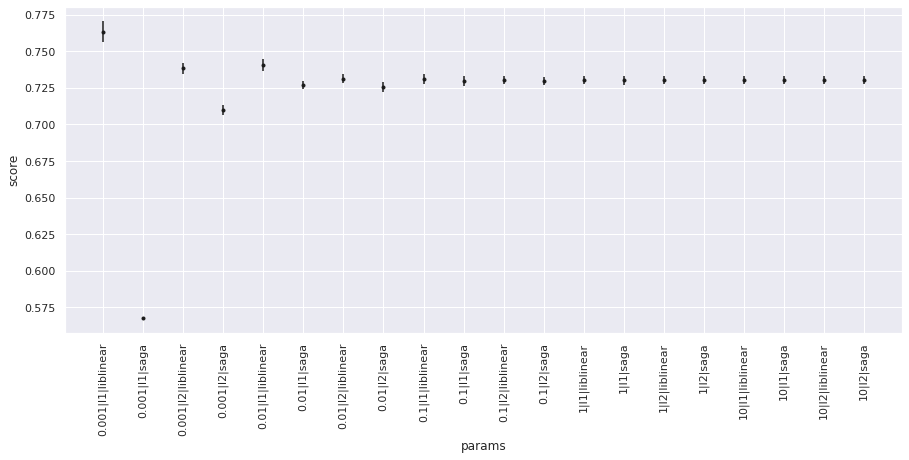

In [19]:
logistic_gscv.fit(X_train, y_train)

show_best(logistic_gscv)

plot_results(logistic_gscv)

Logistic regression seemed to be performing very well right out of the gate. Additionally, there is a very clear best set of hyperparameters with `C` as `0.001`, an L1 regularizer, and `liblinear` as the solver.

Unfortunately, as you will see, many of the following grid searches do not have nearly as clear a winner as this one.

#### SVM

In [20]:
svm_gscv = GridSearchCV(svm_pipe, svm_params_gs, cv=5, verbose=1, scoring='precision')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters:
{'svc__C': 10, 'svc__kernel': 'linear'}
Score: 0.7327675422539793


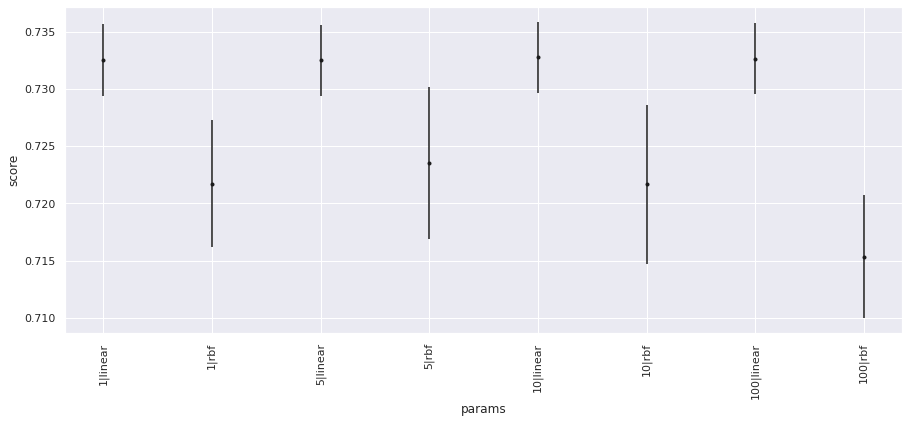

In [21]:
svm_gscv.fit(X_train, y_train)

show_best(svm_gscv)

plot_results(svm_gscv)

It seems that, for our data, using a linear kernel is clearly better than an RBF kernel.

#### K-Nearest Neighbors

In [25]:
knn_gscv = GridSearchCV(knn_pipe, knn_params_gs, cv=5, verbose=1, scoring='precision')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters:
{'neighbors__algorithm': 'brute', 'neighbors__n_neighbors': 11, 'neighbors__weights': 'uniform'}
Score: 0.7267645148857642


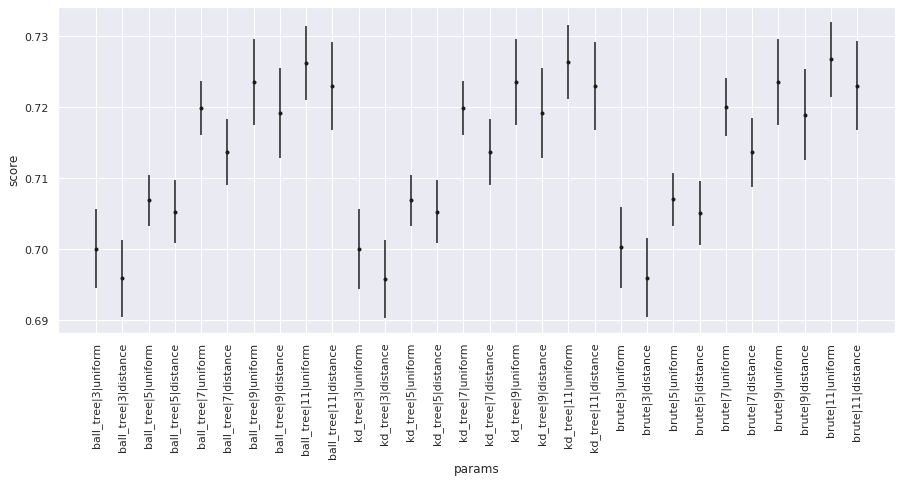

In [26]:
knn_gscv.fit(X_train, y_train)

show_best(knn_gscv)

plot_results(knn_gscv)

As expected, higher values of K perform better across the board. This is because higher values of K should overfit the data. This leads to better scores on this particular set, but less of an ability to generalize. Additionally, using uniform weights for each neighbor was the method that performed better across the board.

Additionally, a brute force search of all neighbors, while slow, was marginally better than the other algorithms. This makes sense because it's likely that KDTree and BallTree cut corners to improve the speed, which costs robustness. With this in mind, we concluded that, because the difference is only marginal, we would perfer a faster algorithm over a brute force search.

### Grid Search (K-Fold)

In [27]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)

#### Logistic Regression

In [28]:
logistic_kfold_gscv = GridSearchCV(logistic_pipe, logistic_params_gs, cv=kf, scoring='precision', verbose=1)

Fitting 7 folds for each of 20 candidates, totalling 140 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Best Parameters:
{'logistic__C': 0.001, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'}
Score: 0.763301112995056


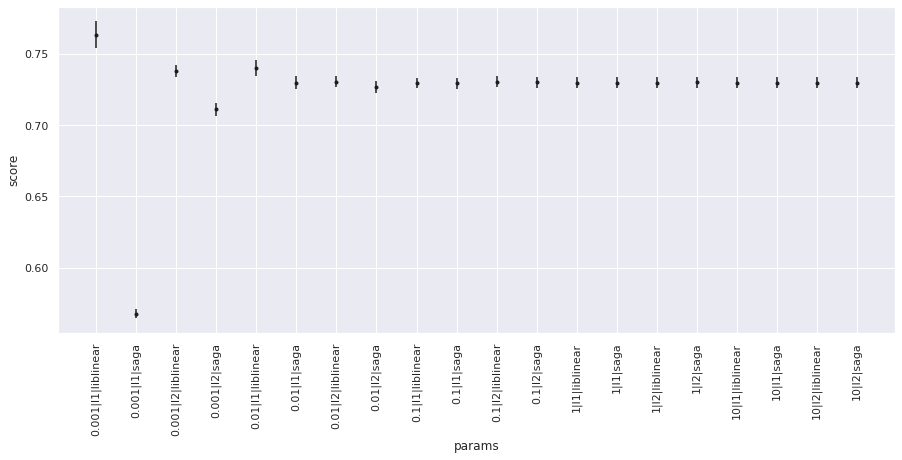

In [36]:
logistic_kfold_gscv.fit(X_train, y_train)

show_best(logistic_kfold_gscv)

plot_results(logistic_kfold_gscv, True)

Similar to the logistic regression plot for stratified K-fold, we notice that, with respect to C-value, the solvers converge from different directions. The saga solver performs worse with a lower C-value, while a liblinear solver performs better.

### Randomized Search (Stratified K-Fold)

#### Random Forest

In [50]:
forest_rscv = RandomizedSearchCV(forest_pipe, forest_params_rs, cv=5, verbose=1, scoring='precision')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:
{'forest__bootstrap': True, 'forest__criterion': 'gini', 'forest__max_depth': 58, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 14, 'forest__n_estimators': 619}
Score: 0.7284233354484386


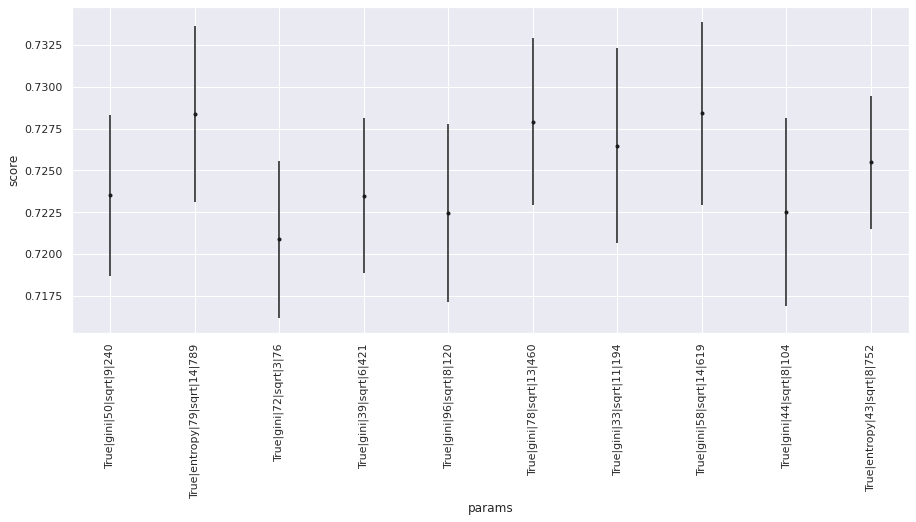

In [51]:
forest_rscv.fit(X_train, y_train)

show_best(forest_rscv)

plot_results(forest_rscv)

The random forest grid search plots for both stratified and standard K-fold ended up being completely unreadable because of the amount of X-labels. This prompted us to remove most of the unnecessary graphs from this section. However, we have stored each of the final grid search plots for viewing in `./ValidationImages`.

This final randomized search random forest was the only readable plot. From the plot above, we can see that, generally, a higher number of estimators leads to a stronger model. However, this likely means overfitting. 

### Validation Results

#### Best logistic regression hyperparameters:
- C:  0.001
- Penalty: L1
- Solver: Liblinear

Score: 0.763301112995056 (K-fold)

#### Best SVM hyperparameters:
- C: 100
- Kernel: Linear

Score: 0.7340175211842775 (K-fold)

#### Best random forest hyperparameters:
- Criterion: Entropy
- Max Depth: 50
- Min Samples Split: 12
- Estimators: 200

Score: 0.7306722469663951 (K-fold)

#### Best KNN hyperparameters:
- Algorithm: Brute-force
- K value: 11
- Weights: Uniform

Score: 0.727857895538188 (K-fold)

### Training the Final Model

In [34]:
from sklearn.metrics import f1_score, precision_score

In [35]:
def run_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print('PRECISION SCORE: ', precision_score(y_test, y_pred))

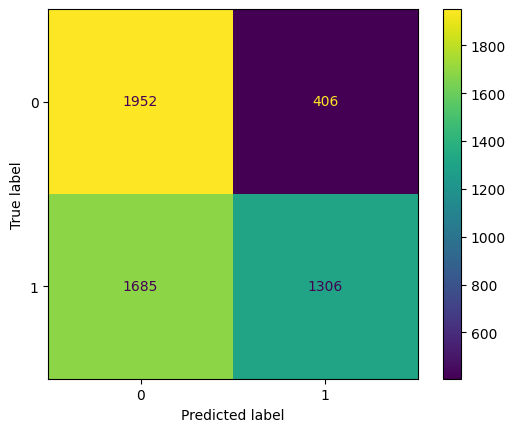

PRECISION SCORE:  0.7628504672897196


In [36]:
run_model(logistic_gscv.best_estimator_)

# Ethics & Privacy

Since the dataset that we are working with is only using publicly available information about Hollywood movies from the Rotten Tomatoes website, our Machine Learning analysis should not end up running into ethical concerns. One consideration we are taking into account is that this dataset has the names of all the movie reviewers in it, which could be an ethical concern if we include their names in our analysis. We’re going to avoid that though by completely ignoring the names of the critics and dropping it from the data since their names are irrelevant to our project. 

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech information above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

An issue we ran into when cleaning, organizing, and selecting features was that some of the features contained too many discrete values to reasonably one-hot encode. Our original dataset had 22 features. We had to reduce this because many of them were unnecessary. Two of these features were the director's name and the names of the main actors and actressed. We think that there could potentially be a connection between director and movie rating as well as a connection between the cast members and the movie's rating. The issue with these columns, however, is that there are thousands of different actors and thousands of different combinations of cast members. Because of this, there was not enough samples with each combination of cast members or director for our model to meaningfully train on. It is likely that if we had analyzed this, there would have been at most something like 5 samples for a single director. We believed that this would not be enough for a model to extract a connection from.

Furthermore, because we prioritized precision score during our validation, we had to sacrifice recall score. However, as mentioned previously, this was a conscious decision that we made because false positives are more "expensive" than false negatives.

In terms of exploring other features, something that we think could be beneficial to have is certain qualities of the frames of the movie. For example, a measure of how colorful the movie is would likely be a reasonable predictor of the rating a movie recieves. Similarly, the average brightness of a movie could be a predictor of the ratings. We believe genre would be an important factor as well when making predictions based on image qualities like this. Supposed a depressing drama was brightly lit for most of the movie. This would most likely not match the mood of the story and therefore lead to lower reviews.

### Ethics & Privacy

Since the dataset that we are working with is only using publicly available information about Hollywood movies from the Rotten Tomatoes website, our Machine Learning analysis should not end up running into ethical concerns. One consideration we are taking into account is that this dataset has the names of all the movie reviewers in it, which could be an ethical concern if we include their names in our analysis. We’re going to avoid that though by completely ignoring the names of the critics and dropping it from the data since their names are irrelevant to our project.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

* we built rotten tomatoes prediction based on some features
* talk about features?
* binary problem

# Footnotes

<div class="footnotes">
<hr>
<ol>
  <li id="cite_note-1">
    <span>Liao, E. (2018, December 8). Can We Predict Rotten Tomatoes Ratings? Towards Data Science. <a href="https://towardsdatascience.com/can-we-predict-rotten-tomatoes-ratings-8b5f5b7d7eff">(source)</a></span>
    <a href="#cite_ref-1" title="Jump back to footnote 1 in the text.">↩</a>
  </li>
  <li id="cite_note-2">
    <span>Maio, A. (2020, March 4). How Does Rotten Tomatoes Actually Work? Studio Binder. <a href="https://www.studiobinder.com/blog/rotten-tomatoes-ratings-system/">(source)</a></span>
    <a href="#cite_ref-2" title="Jump back to footnote 2 in the text.">↩</a>
  </li>
  <li id="cite_note-3">
    <span>Roper, H. (2021, January 20). What makes for a good movie? Towards Data Science. <a href="https://towardsdatascience.com/what-makes-for-a-good-movie-8e10896e0f1b">(source)</a></span>
    <a href="#cite_ref-3" title="Jump back to footnote 3 in the text.">↩</a>
  </li>
</ol>
</div>
